<a href="https://colab.research.google.com/github/MuhammadMazid/Classify-LEGO-StarWars-Figure/blob/main/classify_LEGO_StarWars_Figure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import random
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
base_dir = 'C:\\Users\\muham\\Desktop\\star-wars\\'
names = ["YODA", "LUKE SKYWALKER", "R2-D2", "MACE WINDU", "GENERAL GRIEVOUS"]
tf.random.set_seed(1)

In [ ]:
#Read data

if not os.path.isdir(base_dir + 'train\\'):
  for name in names:
    os.makedirs(base_dir + 'train\\' + name)
    os.makedirs(base_dir + 'test\\' + name)
    os.makedirs(base_dir + 'val\\' + name)


In [ ]:
original_foldars = ["0001/", "0002/", "0003/", "0004/", "0005/"]
for folder_idx, folder in enumerate(original_foldars):
  files = os.listdir(base_dir + folder)
  number_of_images = len([name for name in files])
  n_train=int((number_of_images*0.6)+0.5)
  n_valid=int((number_of_images*0.25)+0.5)
  n_test = number_of_images - n_train - n_valid
  print(number_of_images, n_train, n_valid, n_test)

  for idx, file in enumerate(files):
    file_name = base_dir+folder+file
    if idx<n_train:
      shutil.move(file_name, base_dir + "train\\" + names[folder_idx])
    elif idx < n_train + n_valid:
      shutil.move(file_name, base_dir + "val\\" + names[folder_idx])
    else:
      shutil.move(file_name, base_dir + "test\\" + names[folder_idx])

0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0
0 0 0 0


In [ ]:
n_train = 0
n_valid = 0
n_test = 0

for name in names:
  n_train += len(os.listdir(base_dir + 'train\\'+ name))
  n_valid += len(os.listdir(base_dir + 'val\\'+ name))
  n_test += len(os.listdir(base_dir + 'test\\'+ name))

print(n_train, n_valid, n_test)


37 16 10


In [ ]:
##generating batches of tensor and scaling

image_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)

train_batches = image_gen.flow_from_directory(base_dir + 'train\\',
                                              target_size=(256,256),
                                              class_mode='sparse',
                                              batch_size=4,
                                              shuffle=True,
                                              color_mode='rgb',
                                              classes = names)


val_batches = image_gen.flow_from_directory(base_dir + 'val\\',
                                              target_size=(256,256),
                                              class_mode='sparse',
                                              batch_size=4,
                                              shuffle=False,
                                              color_mode='rgb',
                                              classes = names)


test_batches = image_gen.flow_from_directory(base_dir + 'test\\',
                                              target_size=(256,256),
                                              class_mode='sparse',
                                              batch_size=4,
                                              shuffle=False,
                                              color_mode='rgb',
                                              classes = names)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [ ]:
train_batch = train_batches[0]
print(train_batch[0].shape)
print(train_batch[1])

(4, 256, 256, 3)
[4. 2. 4. 1.]


In [ ]:
train_batch[0][1][:,:,0].shape

(256, 256)

In [ ]:
def show(batch, pred_labels=None):
    plt.figure(figsize=(10,10))
    for i in range(4):
        plt.subplot(2,2,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(batch[0][i], cmap=plt.cm.binary)
        # The CIFAR labels happen to be arrays,
        # which is why you need the extra index
        lbl = names[int(batch[1][i])]
        if pred_labels is not None:
            lbl += "/ Pred:" + names[int(pred_labels[i])]
        plt.xlabel(lbl)
    plt.show()

#show(test_batch)

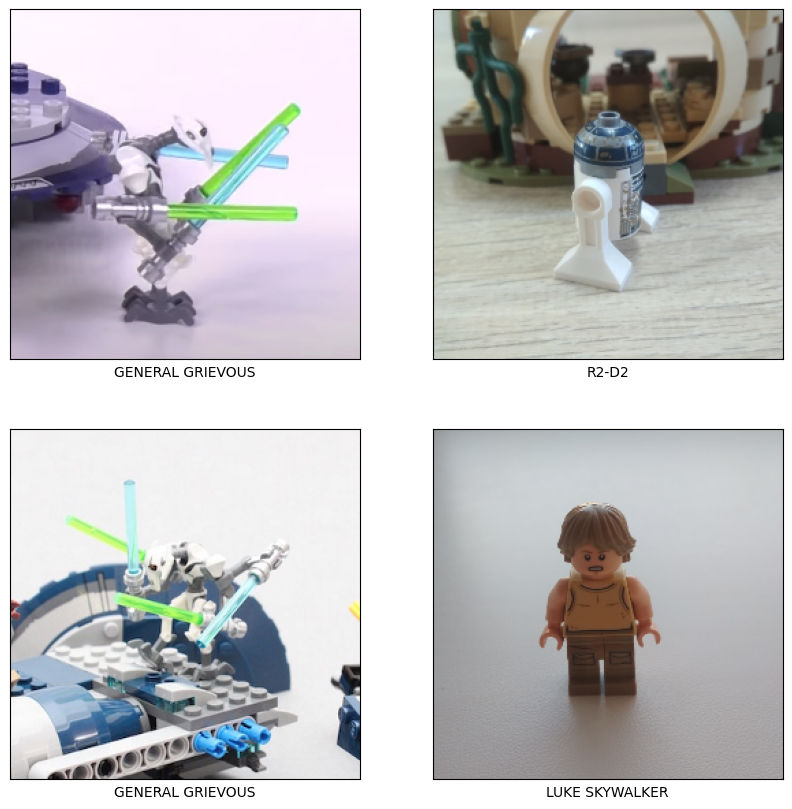

In [ ]:
show(train_batch)


In [ ]:
#desigining model

model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3,3), strides=(1,1), padding="valid", activation='relu', input_shape=(256, 256,3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dense(5))

print(model.summary())



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 246016)            0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [ ]:
#loss and optimizer

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.01)
metrics = ['accuracy']

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [ ]:
#training

epochs = 30

#callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

history = model.fit(train_batches, validation_data=val_batches, callbacks=[early_stopping],
                    epochs=epochs, verbose=2)

Epoch 1/30
10/10 - 3s - loss: 41.8283 - accuracy: 0.1081 - val_loss: 2.6641 - val_accuracy: 0.1875 - 3s/epoch - 265ms/step
Epoch 2/30
10/10 - 2s - loss: 2.0412 - accuracy: 0.1351 - val_loss: 1.6111 - val_accuracy: 0.1875 - 2s/epoch - 208ms/step
Epoch 3/30
10/10 - 2s - loss: 1.6151 - accuracy: 0.2162 - val_loss: 1.6095 - val_accuracy: 0.1875 - 2s/epoch - 217ms/step
Epoch 4/30
10/10 - 2s - loss: 1.6106 - accuracy: 0.2162 - val_loss: 1.6105 - val_accuracy: 0.1875 - 2s/epoch - 212ms/step
Epoch 5/30
10/10 - 2s - loss: 1.6118 - accuracy: 0.2162 - val_loss: 1.6097 - val_accuracy: 0.1875 - 2s/epoch - 210ms/step
Epoch 6/30
10/10 - 2s - loss: 1.6101 - accuracy: 0.2162 - val_loss: 1.6099 - val_accuracy: 0.1875 - 2s/epoch - 208ms/step
Epoch 7/30
10/10 - 2s - loss: 1.6088 - accuracy: 0.2162 - val_loss: 1.6101 - val_accuracy: 0.1875 - 2s/epoch - 208ms/step
Epoch 8/30
10/10 - 2s - loss: 1.6084 - accuracy: 0.2162 - val_loss: 1.6107 - val_accuracy: 0.1875 - 2s/epoch - 208ms/step
Epoch 8: early stopping

In [ ]:
model.save("lego_model.h5")

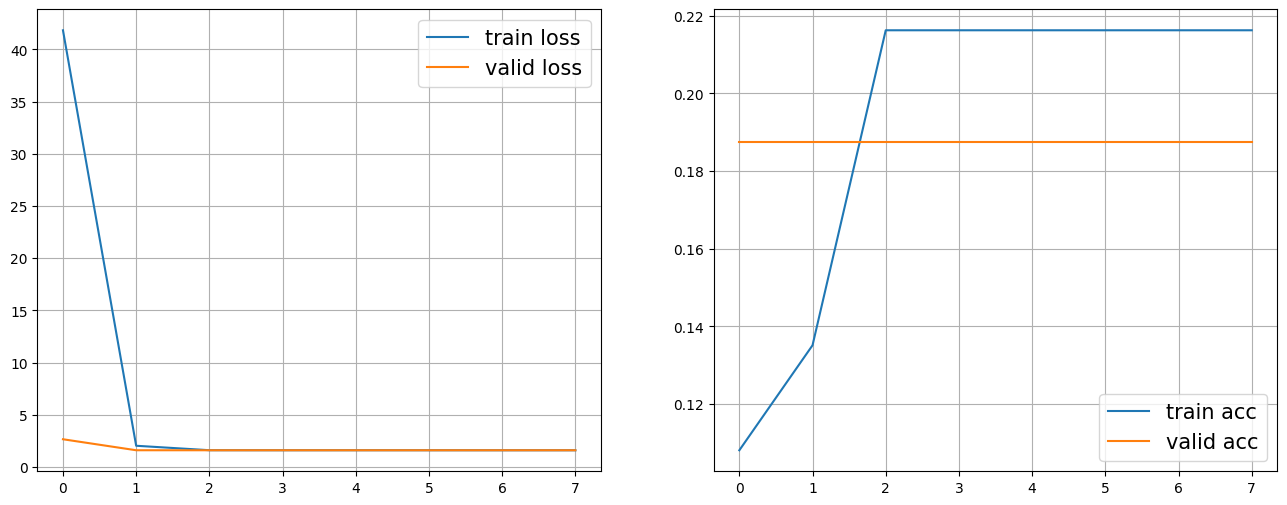

In [ ]:
# plot loss and acc
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15);

In [ ]:

# evaluate on test data
model.evaluate(test_batches, verbose=2)

3/3 - 0s - loss: 1.6114 - accuracy: 0.2000 - 105ms/epoch - 35ms/step


[1.6113513708114624, 0.20000000298023224]

In [ ]:
# make some predictions
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

3/3 [==============================] - 0s 19ms/step
[0. 0. 1. 1.]
[3 3 3 3]


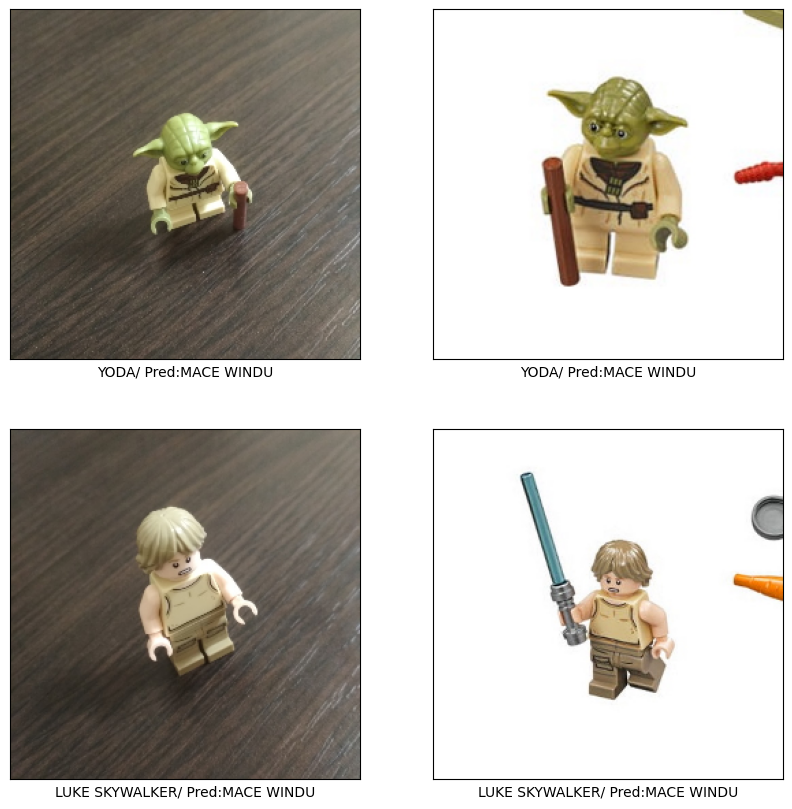

In [ ]:
show(test_batches[0], labels[0:4])


Transfer Learning

In [ ]:
vgg_model = tf.keras.applications.vgg16.VGG16()

print(type(vgg_model))

vgg_model.summary()

553467096/553467096 [==============================] - 11s 0us/step
<class 'keras.engine.functional.Functional'>
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
              

In [ ]:
model = keras.models.Sequential()
for layer in vgg_model.layers[0:-1]:
  model.add(layer)


In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
for layer in model.layers:
  layer.trainable = False

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                                 
 block3_conv1 (Conv2D)       (None, 56, 56, 256)      

In [ ]:
model.add(layers.Dense(5))

#loss and optimizer

loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = keras.optimizers.Adam(learning_rate=0.01)
metrics = ['accuracy']

model.compile(optimizer=optim, loss=loss, metrics=metrics)

In [ ]:
preprocess_input = tf.keras.applications.vgg16.preprocess_input

##generating batches of tensor and scaling

image_gen = keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

train_batches = image_gen.flow_from_directory(base_dir + 'train\\',
                                              target_size=(224,224),
                                              class_mode='sparse',
                                              batch_size=4,
                                              shuffle=True,
                                              color_mode='rgb',
                                              classes = names)


val_batches = image_gen.flow_from_directory(base_dir + 'val\\',
                                              target_size=(224,224),
                                              class_mode='sparse',
                                              batch_size=4,
                                              shuffle=False,
                                              color_mode='rgb',
                                              classes = names)


test_batches = image_gen.flow_from_directory(base_dir + 'test\\',
                                              target_size=(224,224),
                                              class_mode='sparse',
                                              batch_size=4,
                                              shuffle=False,
                                              color_mode='rgb',
                                              classes = names)

Found 37 images belonging to 5 classes.
Found 16 images belonging to 5 classes.
Found 10 images belonging to 5 classes.


In [ ]:
epochs = 30

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=2
)

history = model.fit(train_batches, validation_data=val_batches,
          callbacks=[early_stopping],
          epochs=epochs, verbose=2)

Epoch 1/30
10/10 - 3s - loss: 1.2436e-06 - accuracy: 1.0000 - val_loss: 2.5711 - val_accuracy: 0.8750 - 3s/epoch - 300ms/step
Epoch 2/30
10/10 - 3s - loss: 1.7204e-06 - accuracy: 1.0000 - val_loss: 2.5909 - val_accuracy: 0.8750 - 3s/epoch - 302ms/step
Epoch 3/30
10/10 - 3s - loss: 1.8332e-06 - accuracy: 1.0000 - val_loss: 2.5978 - val_accuracy: 0.8750 - 3s/epoch - 295ms/step
Epoch 4/30
10/10 - 3s - loss: 1.8461e-06 - accuracy: 1.0000 - val_loss: 2.5995 - val_accuracy: 0.8750 - 3s/epoch - 291ms/step
Epoch 5/30
10/10 - 3s - loss: 1.8428e-06 - accuracy: 1.0000 - val_loss: 2.5999 - val_accuracy: 0.8750 - 3s/epoch - 295ms/step
Epoch 6/30
10/10 - 3s - loss: 1.8235e-06 - accuracy: 1.0000 - val_loss: 2.5996 - val_accuracy: 0.8750 - 3s/epoch - 296ms/step
Epoch 6: early stopping


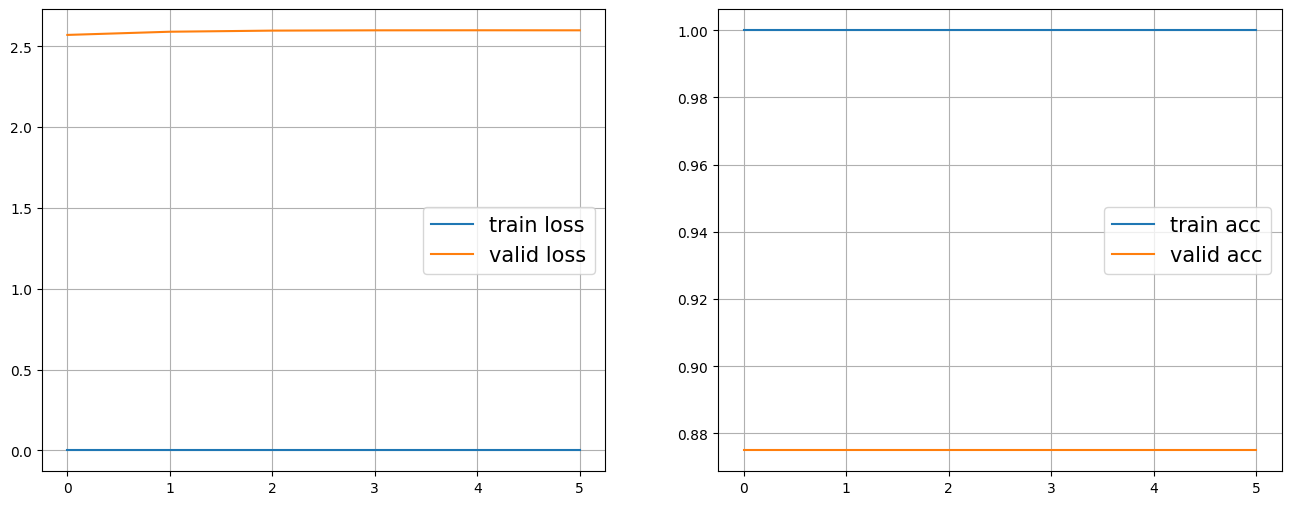

In [ ]:
# plot loss and acc
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='valid loss')
plt.grid()
plt.legend(fontsize=15)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='valid acc')
plt.grid()
plt.legend(fontsize=15);


In [ ]:
# evaluate on test data
model.evaluate(test_batches, verbose=2)

3/3 - 1s - loss: 0.8896 - accuracy: 0.9000 - 632ms/epoch - 211ms/step


[0.8895609974861145, 0.8999999761581421]

In [ ]:
# make some predictions
predictions = model.predict(test_batches)
predictions = tf.nn.softmax(predictions)
labels = np.argmax(predictions, axis=1)

print(test_batches[0][1])
print(labels[0:4])

3/3 [==============================] - 1s 184ms/step
[0. 0. 1. 1.]
[2 0 1 1]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


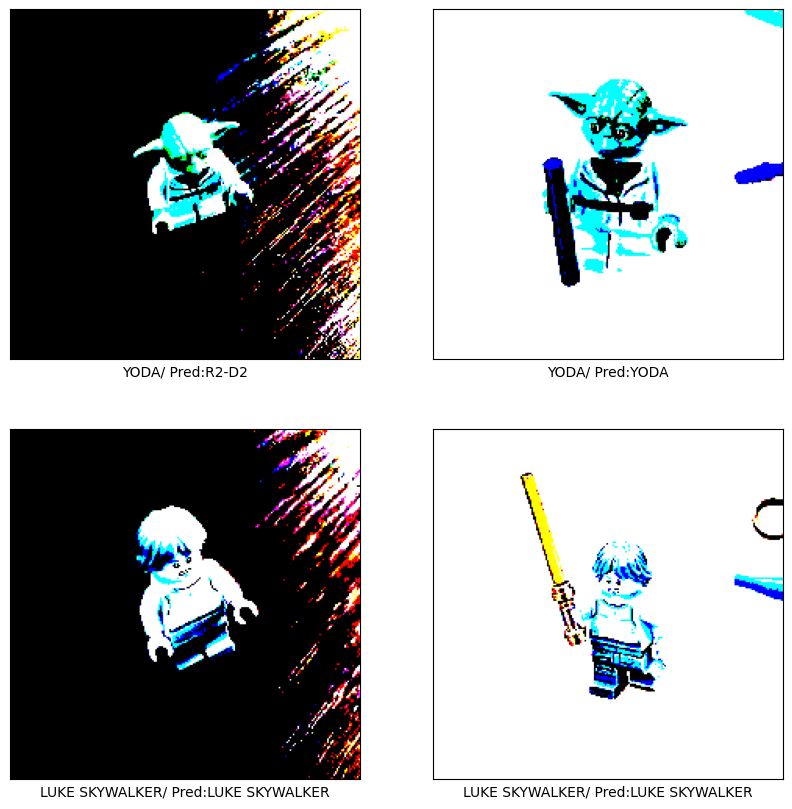

In [ ]:
show(test_batches[0], labels[0:4])
